### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12089
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    47|[28 58 80 58 80 5...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    28|[78 5B 78 5B 20 5...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[10 5A 20 5B A0 5...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[98 5A F0 5A 78 5...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[A0 5B D0 5B 14 5...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
import matplotlib.pyplot as plt

### Select data for a particular station and measurement type

In [26]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00088529')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00088529'
11 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    48|[40 4C 30 55 80 4...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    29|[00 7E 70 5A F0 5...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[E0 54 90 55 F0 5...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[A0 56 80 58 F0 5...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[B0 58 B8 59 60 5...|2006.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[10 5A 30 55 28 5...|2007.0|BSBSSSBS|
|     53.0| 29.9381| -82.11

(11, 365)

In [33]:
temps = []
for i in range(len(T)):
    sum1 = np.nansum(T[i])/np.sum(np.isnan(T[i]))
    temps.append(sum1)

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


In [34]:
temps

[108.41666666666667,
 203.58620689655172,
 inf,
 inf,
 inf,
 inf,
 inf,
 6132.0,
 inf,
 481.23076923076923,
 1332.8]

In [32]:
np.sum(np.isnan(T[0]))

48

In [12]:
# Different kinds of measurement
q1 = "SELECT DISTINCT measurement FROM weather "
df3 = sqlContext.sql(q1)
df3.show()

+-----------+
|measurement|
+-----------+
|       TMIN|
|       TOBS|
|       TMAX|
|       SNOW|
|       SNWD|
|       PRCP|
+-----------+



### Script for plotting yearly plots

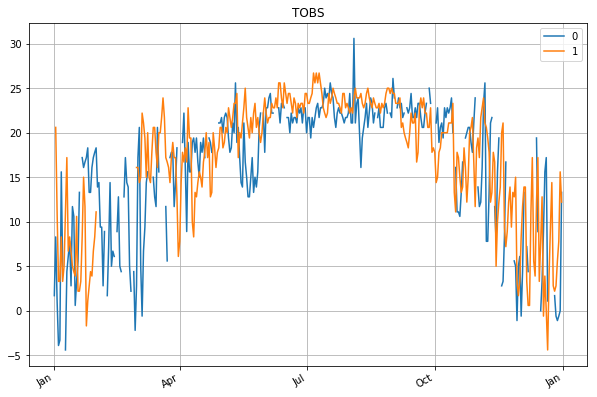

In [13]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TOBS')
#title('A sample of graphs');

Here we see how the precipitation changes over the course of two years - 2000 and 2001.

- We see that there is a periodic increase in the amount of rainfall over the course of months.
- There is maximum precipitation in the month of April in the year 2000 but it's not so high in 2001, followed by a gradual decrease in the month of May and an increase by end june or july beginning in both the years.
- There is more precipitation between June and October in year 2001 compared to the year 2000. 
- After October the amount of precipitation reduces for both the years but is relatively higher in 2001 than 2000.


Now we see it for all the 13 years


Here the labels 0 to 12 represent the years from 2000 to 2012 respectively. 
- We see that there is an expceptionally high rainfall between March and April in the years 2005 and 2008. It is also the highest amount of precipitation over the course of 12 years.
- Similarly there is an exceptionally high anount of rainfall between November and December in the year 2009
- In most of the years the maximum amount of precipitation is received between the months of June and August

In [23]:
# Plotting the average rainfall over the course of 13 years
avg_TOBS = []
for l in range(len(T)):
    sum_tobs = np.nanmean
    avg_TOBS.append(sum_tobs)

In [25]:
s = np.nanmean(T[0])
print s

16.422


In [ ]:
T

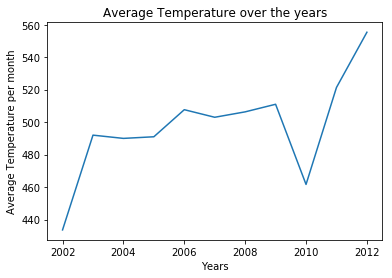

In [16]:
x = np.arange(2002,2013,1)
plt.plot(x,avg_TOBS)
plt.xlabel('Years')
plt.ylabel('Average Temperature per month')
plt.title('Average Temperature over the years')

In [67]:
for i in range(13):
    print np.nansum(T[i])/12

72.5
88.3333333333
115.5
99.5833333333
90.3333333333
98.1666666667
74.125
79.9166666667
79.25
108.083333333
72.4166666667
104.916666667
112.333333333


Now we see the Average distribution of precipitation over the course of 12 years.
- The amount of precipitation is very low in the year 2000 and it increases in 2001 and reaches the peak in 2002. 
- The amount of precipitation is highest in the year 2002 at about 115.5 mm per month
- Then if falls down for the next two years before increasing again in 2005.
- In the year 2006 there is a steep decline in the amount of precipitation to about 74mm and it starts increasing by the year 2007 and stays stable for a year and increases to about 108mm per month in 2009. 
- Again it suddenly plummets to about 72.4 mm per month in 2010 which is the lowest in all the 13 years.
- After 2010 it increases to about 104 in 2011 and to about 112mm per month in 2012

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [80]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

Here we check the amount of missing observations in terms of months. 

In [93]:
STAT

{'PRCP': {'Cov': array([[ 5926.20792373,   905.96344892,   327.68397896, ...,
           -342.62282567,   -79.05863769,   204.34354422],
         [  905.96344892,  7283.03507715,   973.68588202, ...,
            175.65924942,    56.02694946,   108.66264604],
         [  327.68397896,   973.68588202,  5748.66005479, ...,
           -208.79749619,   125.8243489 ,   163.50864518],
         ..., 
         [ -342.62282567,   175.65924942,  -208.79749619, ...,
           4203.39440015,   183.5143402 ,  -115.22597866],
         [  -79.05863769,    56.02694946,   125.8243489 , ...,
            183.5143402 ,  2339.60363216,   397.58609111],
         [  204.34354422,   108.66264604,   163.50864518, ...,
           -115.22597866,   397.58609111,  3674.90659119]]),
  'E': array([  68543.,   73131.,   66863.,   45110.,   30755.,   66383.,
           56623.,   50461.,   49641.,   35325.,   52319.,   60440.,
           60138.,   68433.,   55957.,   44086.,   93450.,   56546.,
           54173.,   575

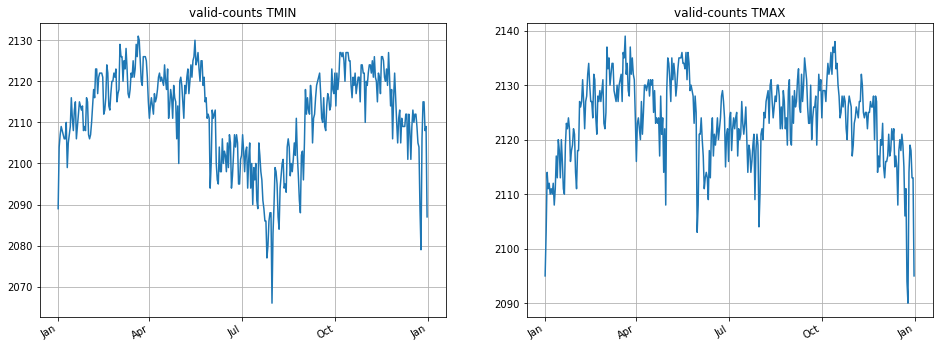

In [81]:
plot_pair(['TMIN','TMAX'],plot_valid)

- From the above graphs we see that most of our data for 'Minimum Temperature' is available between the months Feb to June and between Sept to Dec. Most of the data is missing between the months of July and Sept.
- We have more data available for 'Maximum Temperature' than 'Minimum Temparature'. Most of the data that is missing is in the month of Jan


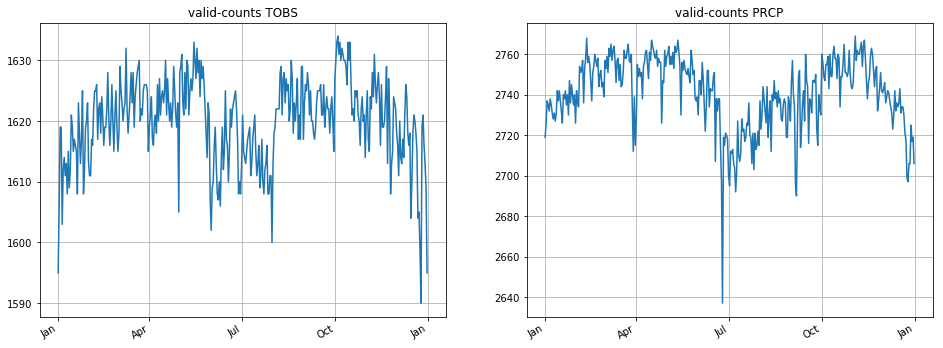

In [72]:
plot_pair(['TOBS','PRCP'],plot_valid)

- For average temperature for each day, most of the data missing in in the month of Jan. We have a slighty less data available between the months of June to September compared to other months.
- For precipitation, most of the missing data is in month of July. For other months, we have a fairly high amount of available data

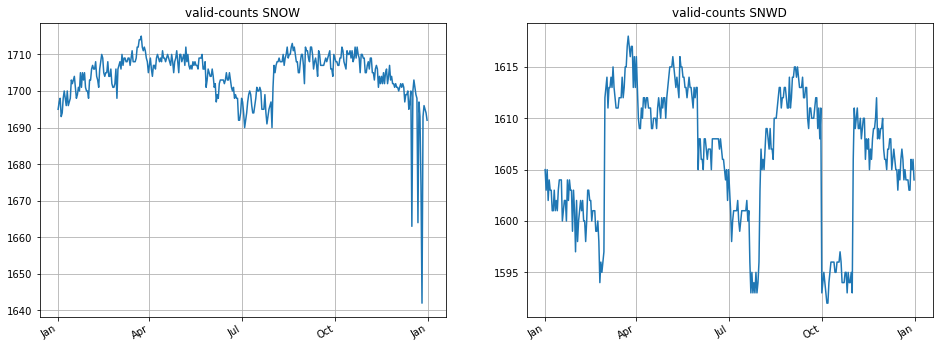

In [73]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

- For amount of snow we have a fairly high amount of data available throughout the year except in late December and the month of Januray.
- For Snow Depth, we have a fluctuating amount of data available over the course of entire year. Most of the missing data is in the months of Feb, March,August, in late October and November.

### Plots of mean and std of observations

In [94]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

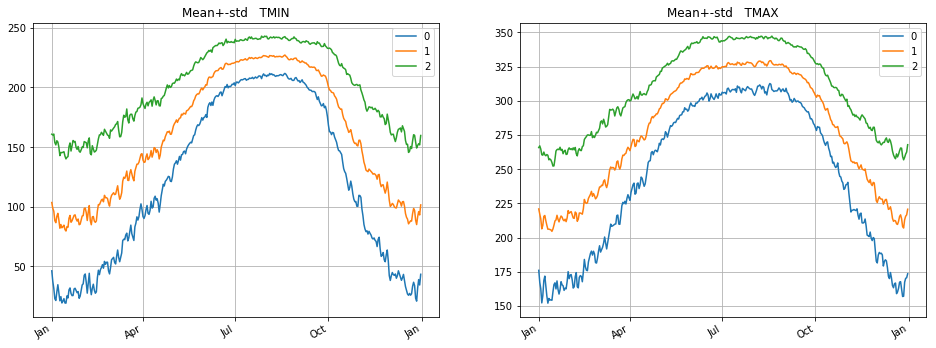

In [95]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

Here curve 1 represents the Mean, curve 0 represents Mean + standard deviation and curve 2 represents Mean - standard deviation.
std dev is more in months between jan and june and between oct and jan as compared to between june and oct. Also, temperature is low in Jan, goes to peak in July/August and falls again until dec. 
- In jan - min temp  - about 100, max temp - 215 - lowest min-max temp
- In July - min temp 220 - max temp - 325 - max min-max temp

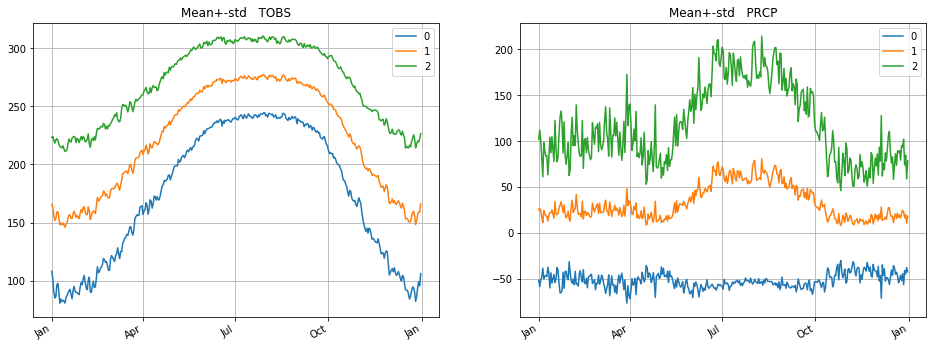

In [96]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

- Avg temp per day in jan is about 150 - Min
- Avg temp per day in July is about 275 - Max

Precipitation
 
- Rains throughout the year. Rainfall about 25mm in Jan to April and increases to above 50 in June end to Sept and then falls down again to around 25

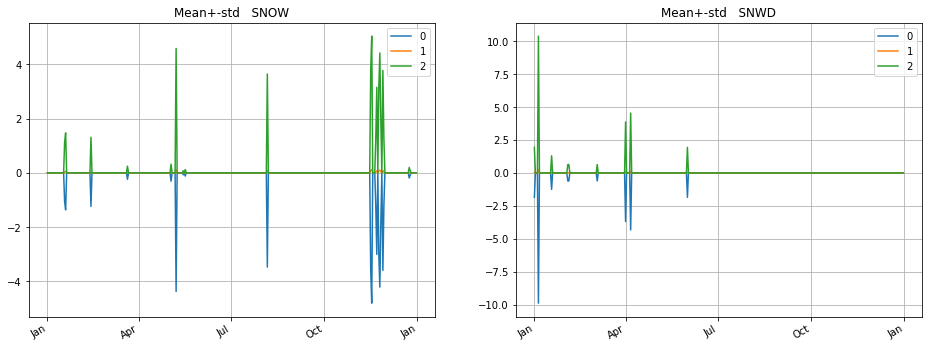

In [97]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

Doesn't snow. These seem to be like outlier data

### plotting top 3 eigenvectors

In [103]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

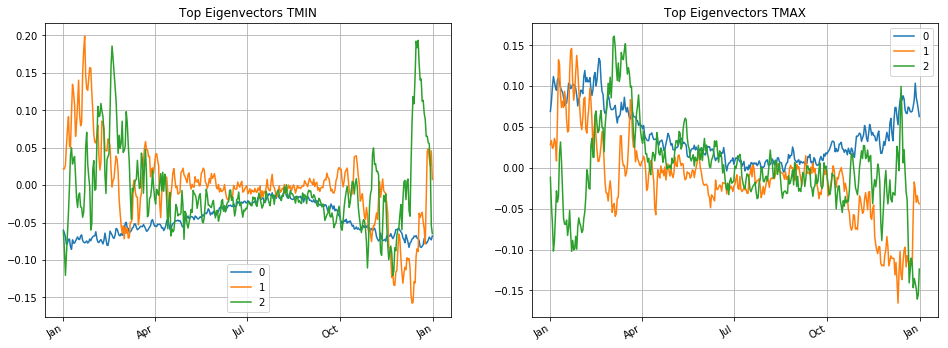

In [104]:
plot_pair(['TMIN','TMAX'],plot_eigen)

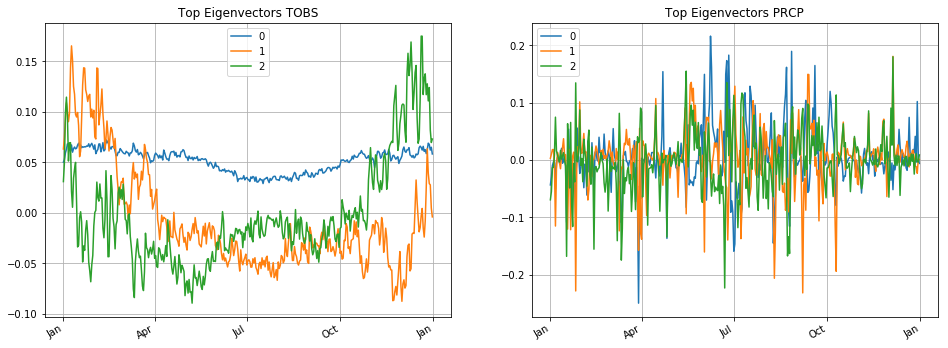

In [110]:
plot_pair(['TOBS','PRCP'],plot_eigen)

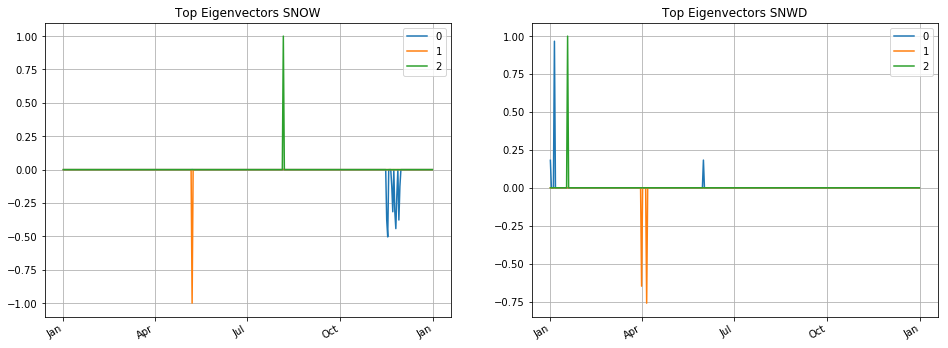

In [106]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [107]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

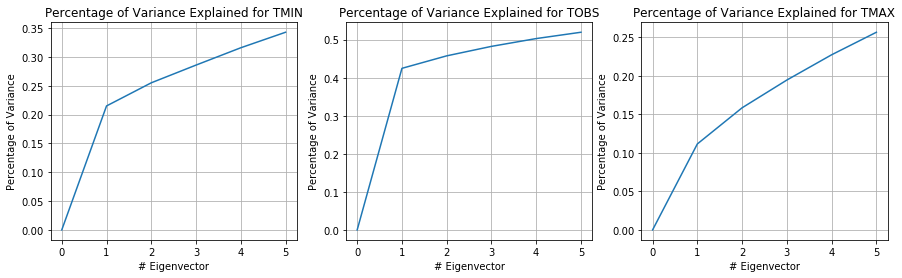

In [108]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

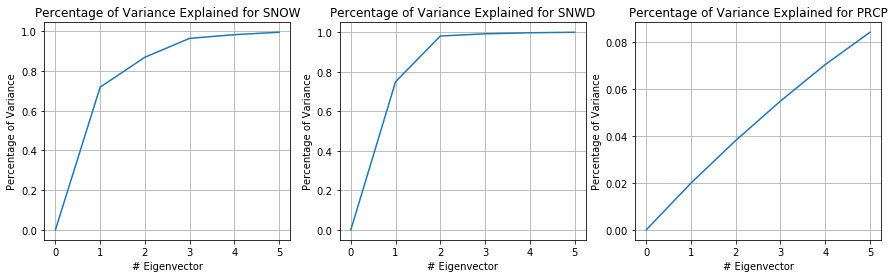

In [109]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()